##  Cloud Composer
### Setting (google cloud shell, Kubernetes Engine API,cloud composer )
✓ Activate Google Cloud Shell <br>
* gcloud auth list <br>
* gcloud config list project <br>
✓ Check project permissions <br>
✓ Ensure that the Kubernetes Engine API is successfully enabled <br>
Kubernetes Engine API > Manage > Disable API > Enable <br>
✓ Ensure that the Cloud Composer API is successfully enabled <br>
Cloud Composer API > Enable  <br>
✓ Cloud Storage > Browser >Create bucket.(output for the Hadoop job ) <br>
✓ Navigation menu > Composer > selecet composer1 and set properties for  environment <br>
click create (10-20 minutes )  <br>

|Property| Value|
|:---|:---|
|Name |highcpu|
|Location |us-central1|
|Zone |us-central1-a|
|Machine type |n1-highcpu-4|


### Airflow and core concepts
While waiting for your Composer environment to get created, review some terms that are used with Airflow.
**Airflow** is a platform to programmatically author, schedule and monitor workflows. <br>
Use Airflow to author workflows as directed acyclic graphs (DAGs) of tasks. The airflow scheduler executes 
your tasks on an array of workers while following the specified dependencies.
Core concepts <br>
**DAG** <br>
A Directed Acyclic Graph is a collection of all the tasks you want to run, organized in a way that reflects their 
relationships and dependencies. <br>
**Operator** <br>
The description of a single task, it is usually atomic. For example, the BashOperator is used to execute bash 
command. <br>
**Task** <br>
A parameterised instance of an Operator; a node in the DAG. <br>
**Task Instance** <br>
A specific run of a task; characterized as: a DAG, a Task, and a point in time. It has an indicative 
state: running, success, failed, skipped, ... <br>

### Defining the workflow
Now let's discuss the workflow you'll be using. Cloud Composer workflows are comprised of DAGs (Directed Acyclic Graphs). DAGs are defined in standard Python files that are placed in Airflow's DAG_FOLDER. Airflow will execute the code in each file to dynamically build the DAG objects. You can have as many DAGs as you want, each describing an arbitrary number of tasks. In general, each one should correspond to a single logical workflow.
Below is the hadoop_tutorial.py workflow code, also referred to as the DAG:



In [ ]:
"""Example Airflow DAG that creates a Cloud Dataproc cluster, 
runs the Hadoop
wordcount example, and deletes the cluster.
This DAG relies on three Airflow variables
https://airflow.apache.org/concepts.html#variables
* gcp_project - Google Cloud Project to use for the Cloud 
Dataproc cluster.
* gce_zone - Google Compute Engine zone where Cloud 
Dataproc cluster should be
created.
* gcs_bucket - Google Cloud Storage bucket to used as output 
for the Hadoop jobs from Dataproc.
See https://cloud.google.com/storage/docs/creating-buckets 
for creating a
bucket.
"""
import datetime
import os
from airflow import models
from airflow.contrib.operators import dataproc_operator
from airflow.utils import trigger_rule
# Output file for Cloud Dataproc job.
output_file = os.path.join(
models.Variable.get('gcs_bucket'), 'wordcount',
datetime.datetime.now().strftime('%Y%m%d-%H%M%S')) + 
os.sep
# Path to Hadoop wordcount example available on every 
#Dataproc cluster.
WORDCOUNT_JAR = (
'file:///usr/lib/hadoop-mapreduce/hadoop-mapreduce-examples.jar'
)
# Arguments to pass to Cloud Dataproc job.
wordcount_args = ['wordcount', 
'gs://pub/shakespeare/rose.txt', output_file]
yesterday = datetime.datetime.combine(
datetime.datetime.today() - datetime.timedelta(1),
datetime.datetime.min.time())
default_dag_args = {
# Setting start date as yesterday starts the DAG immediately 
#when it is
# detected in the Cloud Storage bucket.
'start_date': yesterday,
# To email on failure or retry set 'email' arg to your email and 
#enable
# emailing here.
'email_on_failure': False,
'email_on_retry': False,
# If a task fails, retry it once after waiting at least 5 minutes
'retries': 1,
'retry_delay': datetime.timedelta(minutes=5),
'project_id': models.Variable.get('gcp_project')
}

with models.DAG(
'composer_sample_quickstart',
# Continue to run DAG once per day
schedule_interval=datetime.timedelta(days=1),
default_args=default_dag_args) as dag:
# Create a Cloud Dataproc cluster.
create_dataproc_cluster = 
dataproc_operator.DataprocClusterCreateOperator(
task_id='create_dataproc_cluster',
# Give the cluster a unique name by appending the date scheduled.
# See https://airflow.apache.org/code.html#default-variables
cluster_name='composer-hadoop-tutorial-cluster-{{ 
ds_nodash }}',
num_workers=2,
region='us-central1',
zone=models.Variable.get('gce_zone'),
image_version='2.0',
master_machine_type='n1-standard-2',
worker_machine_type='n1-standard-2')
# Run the Hadoop wordcount example installed on the Cloud  Dataproc cluster
# master node.
run_dataproc_hadoop = 
dataproc_operator.DataProcHadoopOperator(
task_id='run_dataproc_hadoop',
region='us-central1',
main_jar=WORDCOUNT_JAR,
cluster_name='composer-hadoop-tutorial-cluster-{{ 
ds_nodash }}',
arguments=wordcount_args)
# Delete Cloud Dataproc cluster.
delete_dataproc_cluster = 
dataproc_operator.DataprocClusterDeleteOperator(
task_id='delete_dataproc_cluster',
region='us-central1',
cluster_name='composer-hadoop-tutorial-cluster-{{ 
ds_nodash }}',
# Setting trigger_rule to ALL_DONE causes the cluster to 
be deleted
# even if the Dataproc job fails.
trigger_rule=trigger_rule.TriggerRule.ALL_DONE)
# Define DAG dependencies.
create_dataproc_cluster >> run_dataproc_hadoop >> 
delete_dataproc_cluster



### DAG
To orchestrate the three workflow tasks, the DAG imports the following operators: <br>
1.DataprocClusterCreateOperator: Creates a Cloud Dataproc cluster. <br>
2.DataProcHadoopOperator: Submits a Hadoop wordcount job and writes results to a Cloud Storage bucket. <br>
3.DataprocClusterDeleteOperator: Deletes the cluster to avoid incurring ongoing Compute Engine charges. <br>
The tasks run sequentially, which you can see in this section of the file: <br>
--  Define DAG dependencies. <br>
create_dataproc_cluster >> run_dataproc_hadoop >> delete_dataproc_cluster <br>
The name of the DAG is quickstart, and the DAG runs once each 
day. <br>
with models.DAG( <br>
'composer_sample_quick start', <br>
-- Continue to run DAG once per day <br>
schedule_interval=datetime.timedelta(days=1), <br>
default_args=default_dag_args) as dag: <br>
Because the start_date that is passed in to default_dag_args is 
set to yesterday, Cloud Composer schedules the workflow to 
start immediately after the DAG uploads. <br>

Viewing environment information
Go back to Composer to check the status of your environment.
Once your environment has been created, click the name of 
the environment (highcpu) to see its details.
On the Environment details you'll see information such as the 
Airflow web interface URL, Kubernetes Engine cluster ID, and a 
link to the DAGs folder, which is stored in your bucket

### Airflow UI (environment variables)
1.Go back to the Environments page <br>
2.In the Airflow webserver column for the environment, click Airflow. <br>
3.Click on your lab credentials. <br>
4.The Airflow web interface opens in a new browser window. <br>
Setting Airflow variables <br>
Airflow variables are an Airflow-specific concept that is distinct from environment variables. <br>
1.Select Admin > Variables from the Airflow menu bar, then Create. <br>
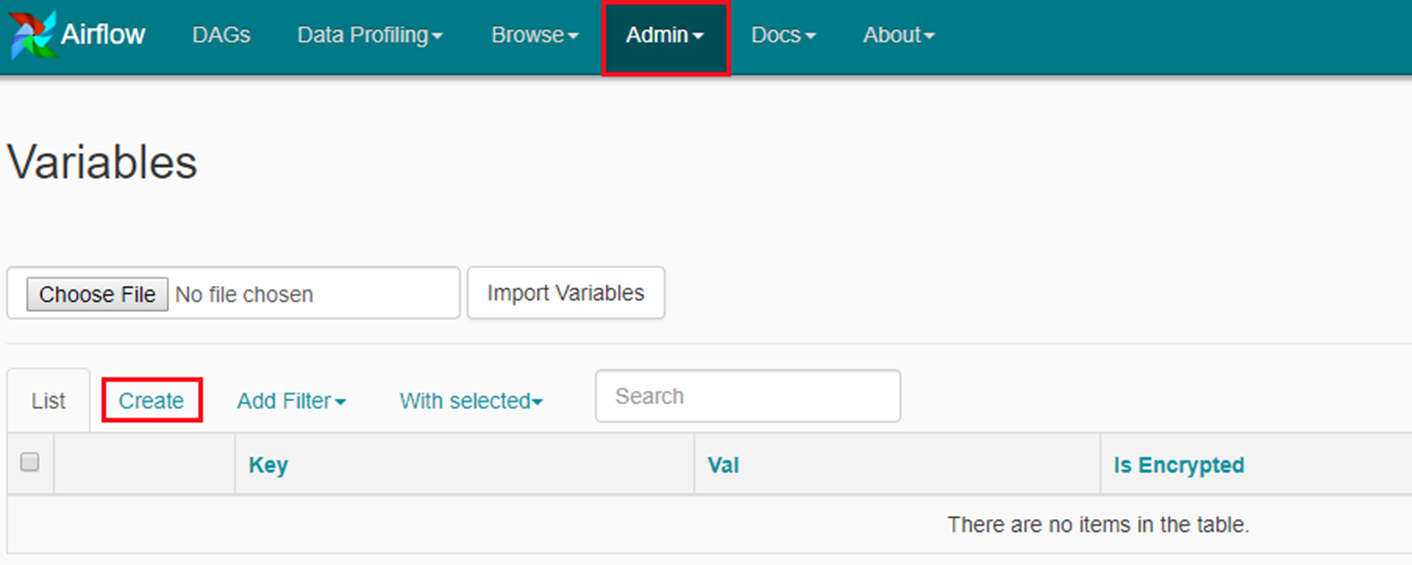

Create the following Airflow variables, gcp_project, gcs_bucket, and gce_zone: <br>

|KEY |VALUE| Details|
|:---|:---|:---|
|gcp_project |your project-id |The Google Cloud Platform project you're using for this quickstart.|
|gcs_bucket |gs://my-bucket |Replace my-bucket with the name of the Cloud Storage bucket you made earlier. This bucket stores the output from the Hadoop jobs from Dataproc.|
|gce_zone |us-central1-a|This is the Compute Engine zone where your Cloud Dataproc cluster will be created. To chose a different zone, see Available regions & zones.|

Click Save and Add Another after adding first two variable 
and click Save for the third variable. Your Variables table 
should look like this when you're finished: <br>

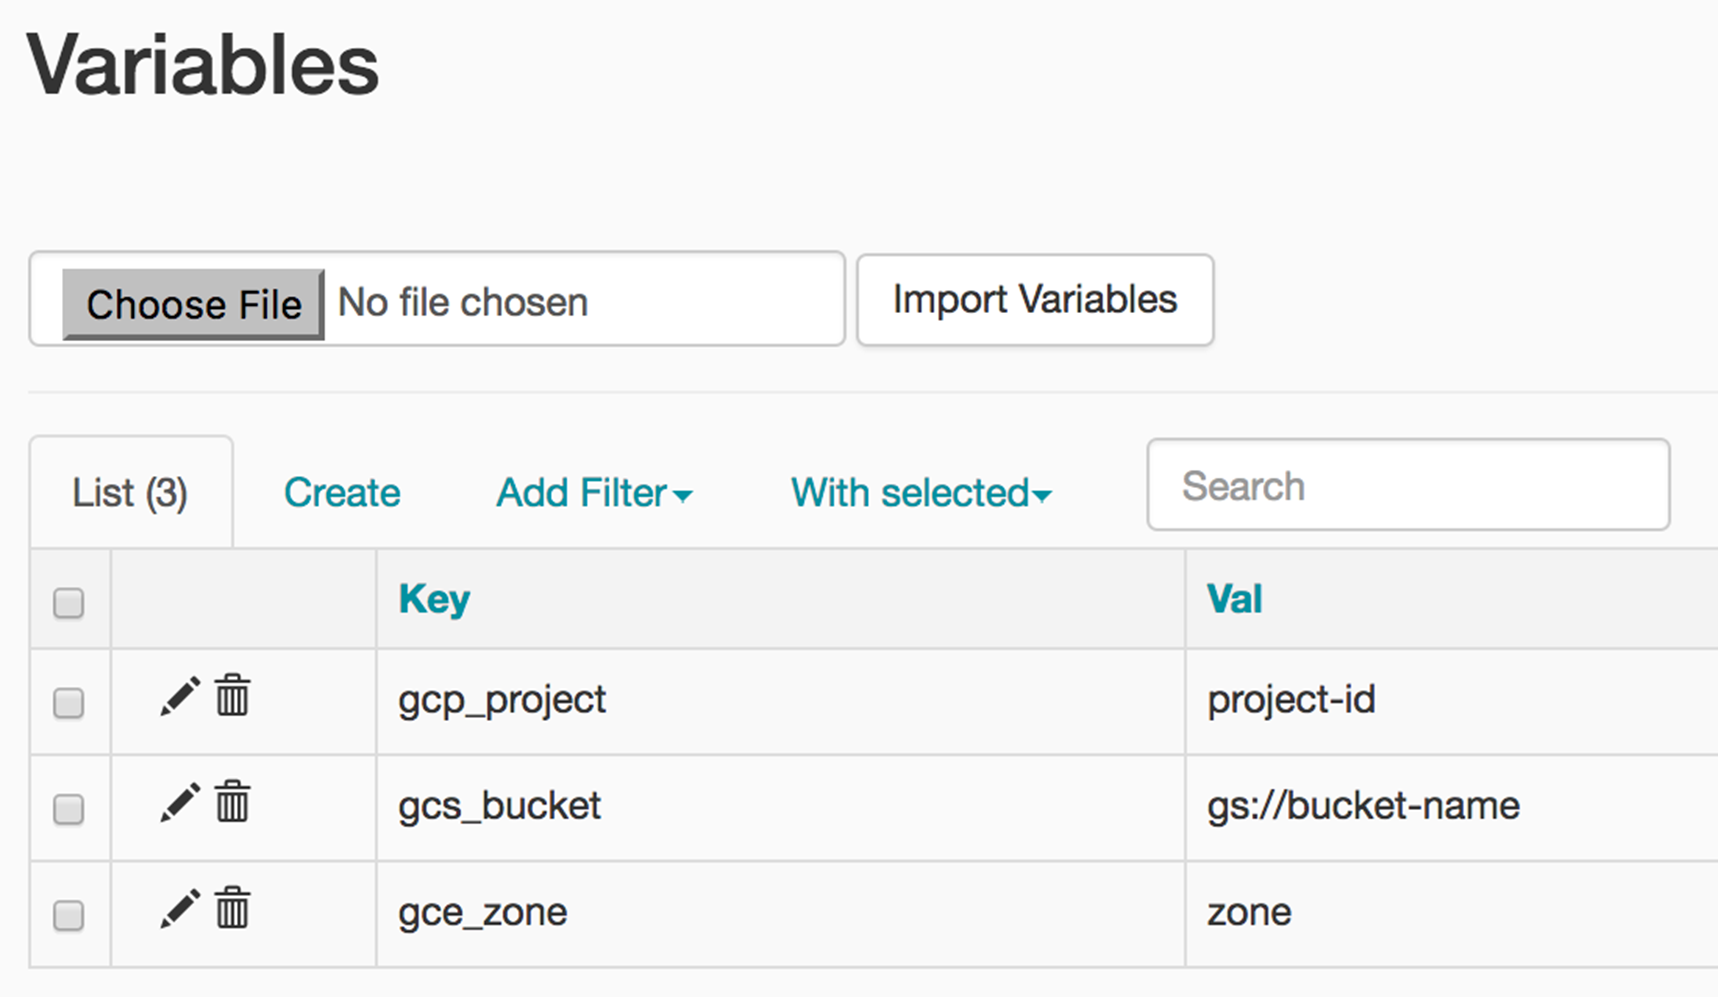

### Uploading the DAG to Cloud Storage
In Cloud Shell, upload a copy of the hadoop_tutorial.py file to the Cloud Storage bucket that was automatically created when you
created the environment. <br>
Replace <DAGs_folder_path> in the following command: <br>
```shell
gsutil cp gs://cloud-training/datawarehousing/lab_assets/hadoop_tutorial.py <DAGs_folder_path>
``` 
with the path to the DAGs folder. You can get the path by going to Composer. Click on the environment you created 
earlier and then click on the Environment Configuration tab to see the details of the environment. Find DAGs folder and 
copy the path. <br>
```shell
gsutil cp gs://cloud-training/datawarehousing/lab_assets/hadoop_tutorial.py gs://us-central1-highcpu-0682d8c0-bucket/dag
```
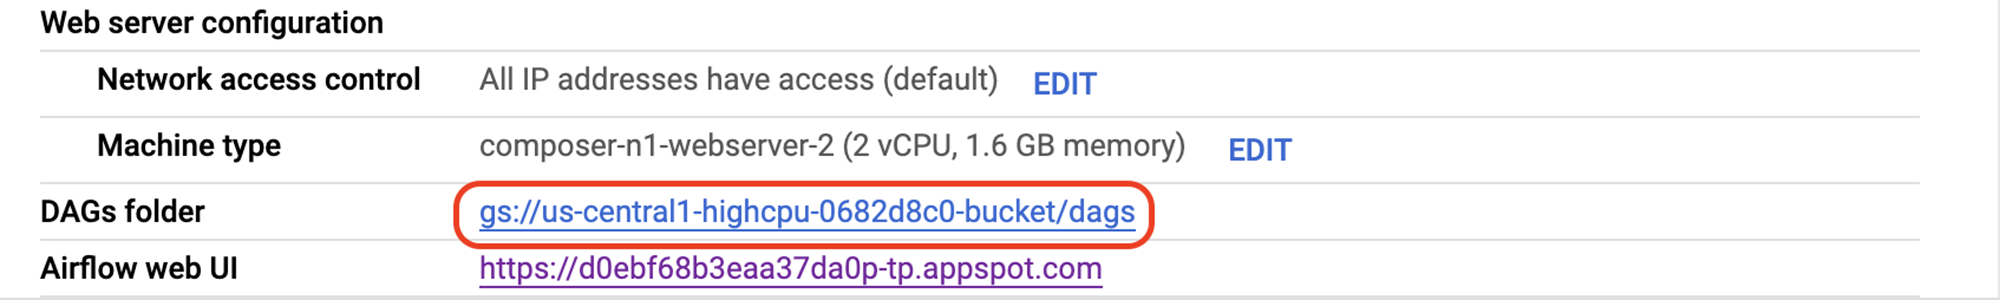

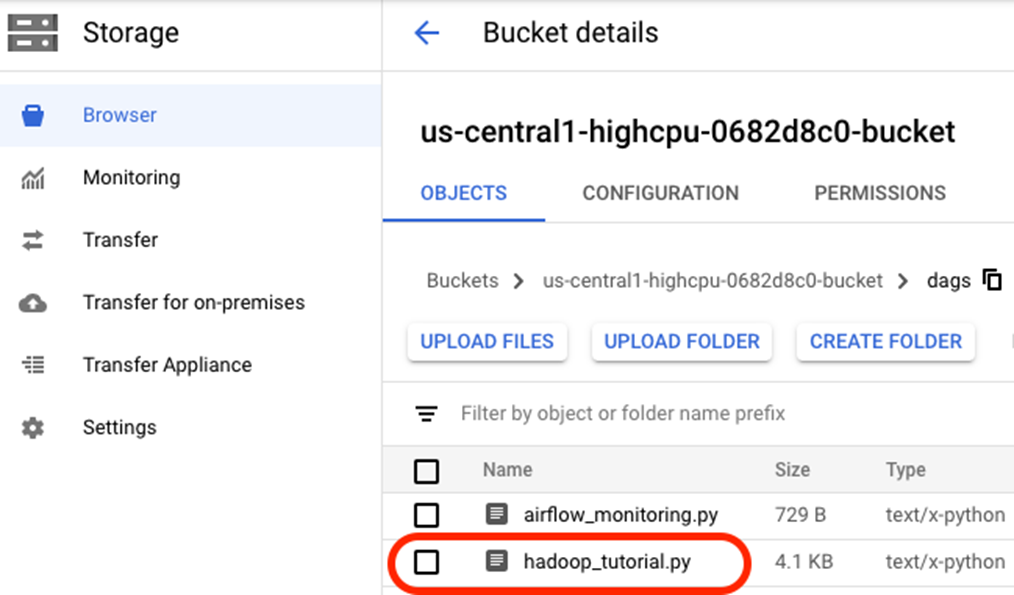

When a DAG file is added to the DAGs folder, Cloud 
Composer adds the DAG to Airflow and schedules it 
automatically. DAG changes occur within 3-5 minutes.
You can see the task status of the 
composer_hadoop_tutorial DAG in the Airflow web 
interface.

### Exploring DAG runs
When you upload your DAG file to the dags folder in Cloud Storage, Cloud Composer parses the file. If no errors are 
found, the name of the workflow appears in the DAG listing, and the workflow is queued to run immediately. <br>
Make sure that you're on the DAGs tab in the Airflow web interface. It takes several minutes for this process to 
complete. Refresh your browser to make sure you're looking at the latest information. <br>

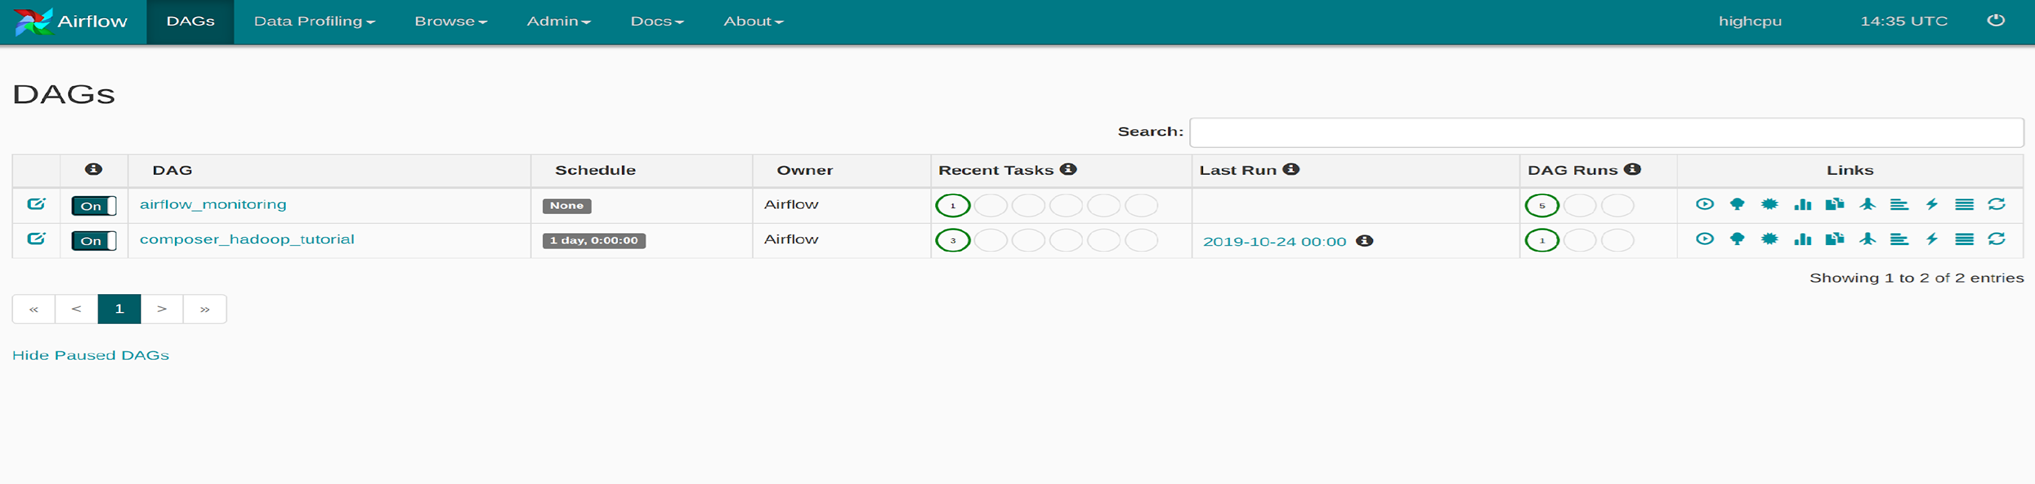

1.In Airflow, click composer_hadoop_tutorial to open the 
DAG details page. This page includes several 
representations of the workflow tasks and dependencies. <br>
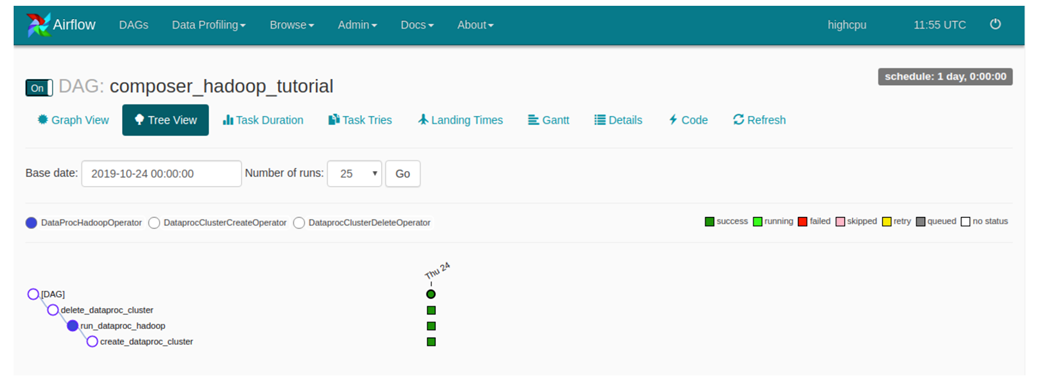

2.In the toolbar, click Graph View. Mouseover the graphic for each task to see its status. Note 
that the border around each task also indicates the status (green border = running; red = failed, 
etc.). <br>

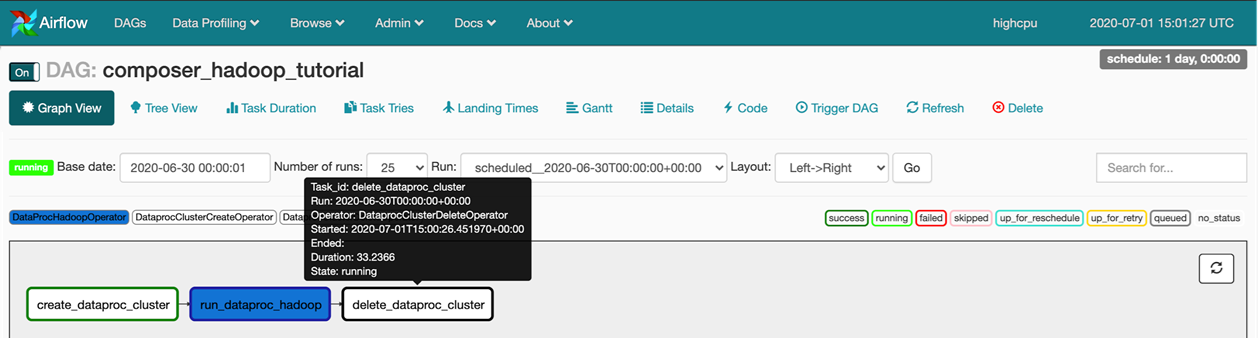

3.Click the "Refresh" link to make sure you're looking at the most recent information. The borders of the processes 
change colors as the state of the process changes
Note: If your Dataproc cluster already exists, you can run the workflow again to reach the success state by 
clicking create_dataproc_cluster graphic and then click Clear to reset the three tasks and click OK to confirm. <br>
4.Once the status for create_dataproc_cluster has changed to "running", go to Navigation menu > Dataproc, then click 
on: <br>
•Clusters to monitor cluster creation and deletion. The cluster created by the workflow is ephemeral: it only exists for 
the duration of the workflow and is deleted as part of the last workflow task. <br>
•Jobs to monitor the Apache Hadoop wordcount job. Click the Job ID to see job log output. <br>
5.Once Dataproc gets to a state of "Running", return to Airflow and click Refresh to see that the cluster is complete.
When the run_dataproc_hadoop process is complete, go to Navigation menu > Cloud Storage > Browser and click on the 
name of your bucket to see the results of the wordcount in the wordcount folder. <br>
6.Once all the steps are complete in the DAG, each step has a dark green border. Additionally the Dataproc cluster that 
was created is now deleted <br>